In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

In [474]:
loan = '/content/lending_club_loan_dataset.csv'
ld = pd.read_csv(loan)
ld.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [475]:
ld.duplicated().sum()

0

In [476]:
ld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_inc             20000 non-null  float64
 3   short_emp              20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   dti                    19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

In [477]:
ld.isna().sum()

id                           0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64

Remove the "last_major_derog_none" column from the dataset due to a large 
portion of missing data.

In [478]:
ld = ld.drop(columns=['last_major_derog_none','id'])

In [479]:
ld['home_ownership'].value_counts()

MORTGAGE    9844
RENT        7052
OWN         1613
Name: home_ownership, dtype: int64

Use the most frequent value in the "home_ownership" column for missing data.

In [480]:
ld['home_ownership'].fillna('MORTGAGE', inplace=True)

Use the mean value of the "dti" column for missing data for consistency.

In [481]:
ld['dti'].fillna(ld['dti'].mean(), inplace=True)
ld.isna().sum()

grade                 0
annual_inc            0
short_emp             0
emp_length_num        0
home_ownership        0
dti                   0
purpose               0
term                  0
last_delinq_none      0
revol_util            0
total_rec_late_fee    0
od_ratio              0
bad_loan              0
dtype: int64

In [482]:
categories = ["grade", "annual_inc", "short_emp", "emp_length_num",
              "home_ownership", "dti", "purpose", "term", "last_delinq_none",
              "revol_util", "total_rec_late_fee", "od_ratio", "bad_loan"]
for values in categories:
  print("\n", values)
  print(ld[values].value_counts())


 grade
B    6042
C    5566
D    3554
A    2159
E    1645
F     865
G     169
Name: grade, dtype: int64

 annual_inc
60000.0     787
50000.0     735
65000.0     609
70000.0     608
80000.0     548
           ... 
112711.0      1
66389.0       1
62212.0       1
44289.0       1
93250.0       1
Name: annual_inc, Length: 2566, dtype: int64

 short_emp
0    17750
1     2250
Name: short_emp, dtype: int64

 emp_length_num
11    6530
3     1732
4     1501
1     1453
6     1405
8     1316
7     1246
2     1227
5     1026
9      989
0      797
10     778
Name: emp_length_num, dtype: int64

 home_ownership
MORTGAGE    11335
RENT         7052
OWN          1613
Name: home_ownership, dtype: int64

 dti
16.587841    154
15.870000     20
19.640000     20
11.450000     19
19.250000     19
            ... 
33.270000      1
3.180000       1
2.630000       1
33.440000      1
32.530000      1
Name: dti, Length: 3296, dtype: int64

 purpose
debt_consolidation    12337
credit_card            4137
home_improv

Fix inconsistency in "term" column

In [483]:
ld['term'] = ld['term'].replace([' 36 Months'], ' 36 months')
ld['term'].value_counts()

 36 months    15001
 60 months     4999
Name: term, dtype: int64

In [484]:
ld.dtypes

grade                  object
annual_inc            float64
short_emp               int64
emp_length_num          int64
home_ownership         object
dti                   float64
purpose                object
term                   object
last_delinq_none        int64
revol_util            float64
total_rec_late_fee    float64
od_ratio              float64
bad_loan                int64
dtype: object

The graphs below show the count for all numerical data in the dataset.
We can identify the outliers in these graphs by the difference of one value
when compared to the other values.

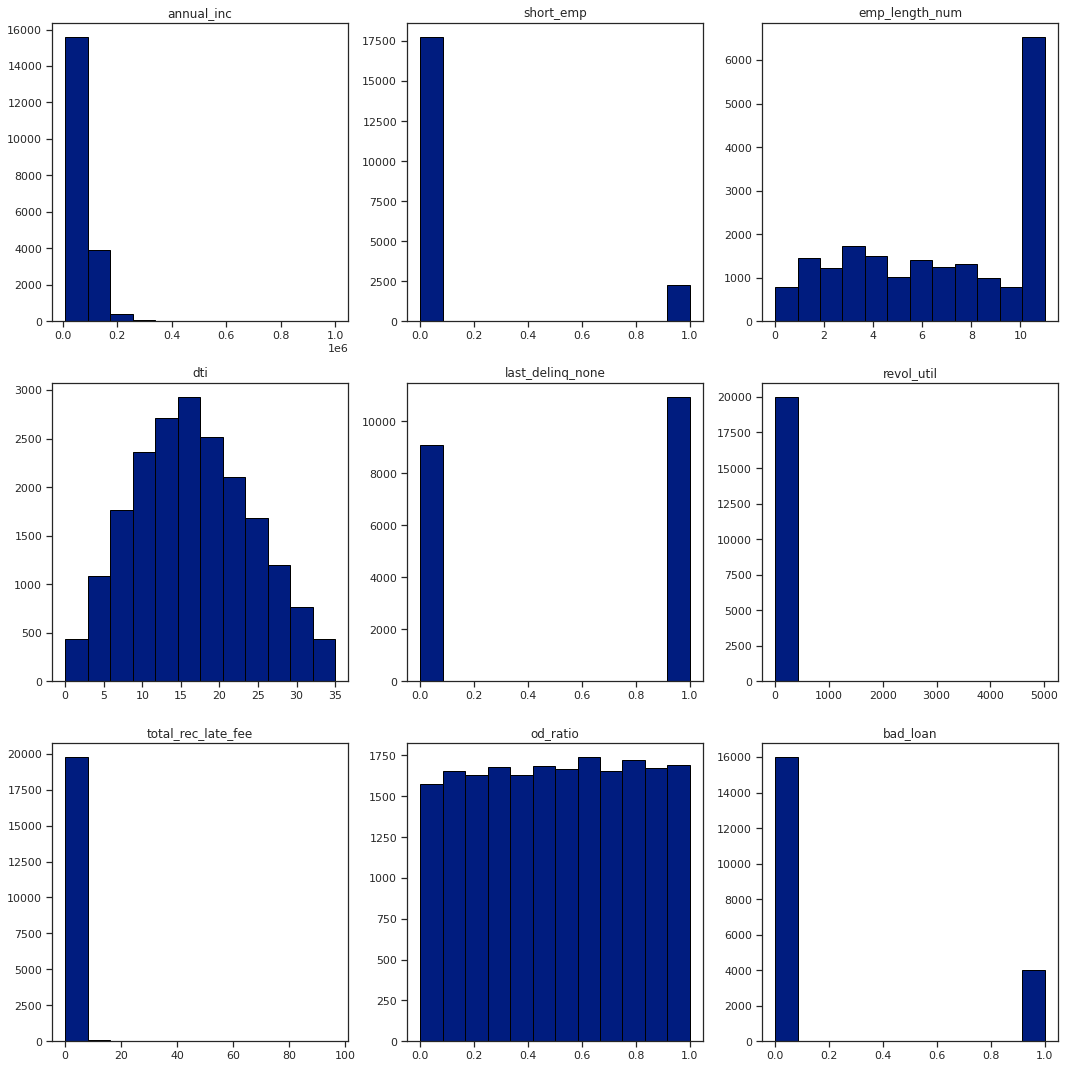

In [485]:
ld.hist(figsize=(15,15), bins=12, ec='black', grid=False)
plt.tight_layout()

The graphs below show the count for all categorical data in the dataset.
We can identify the outliers in these graphs by the difference of one value
when compared to the other values.

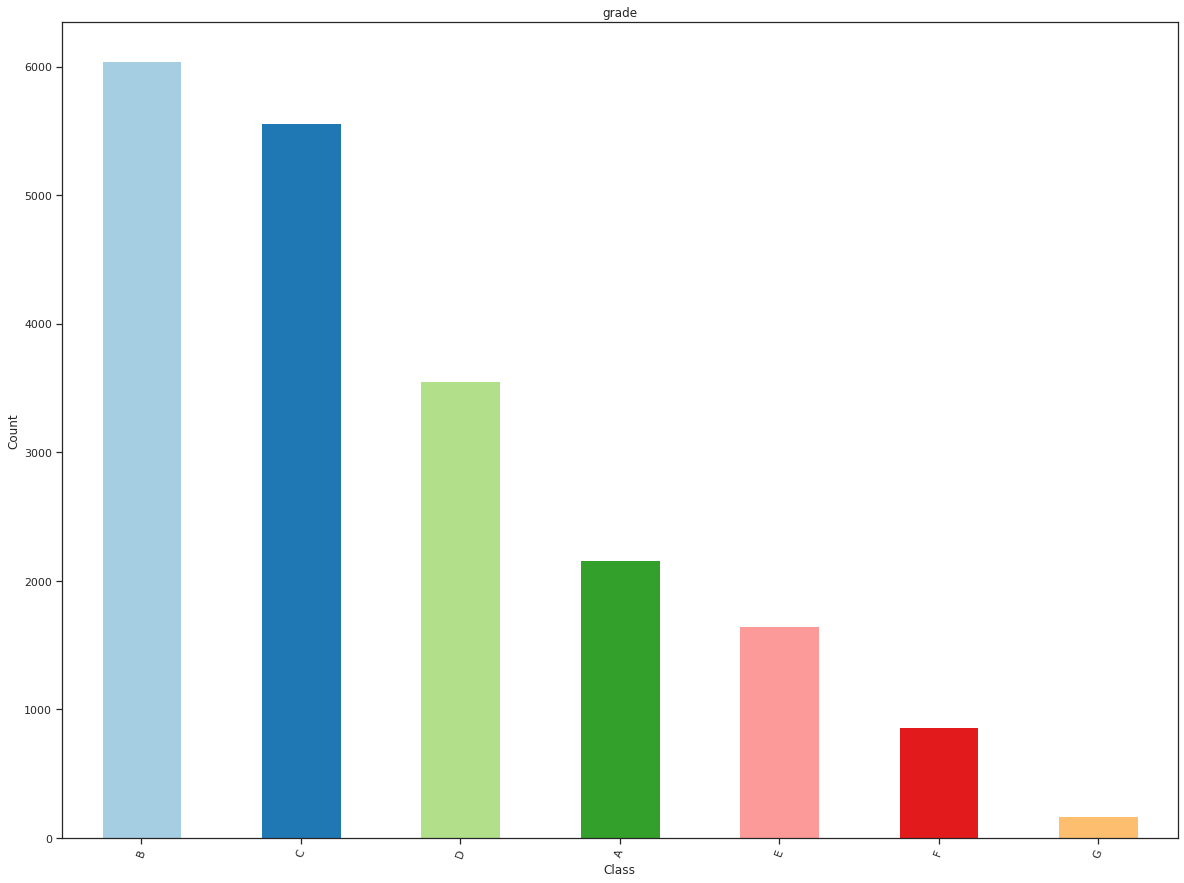

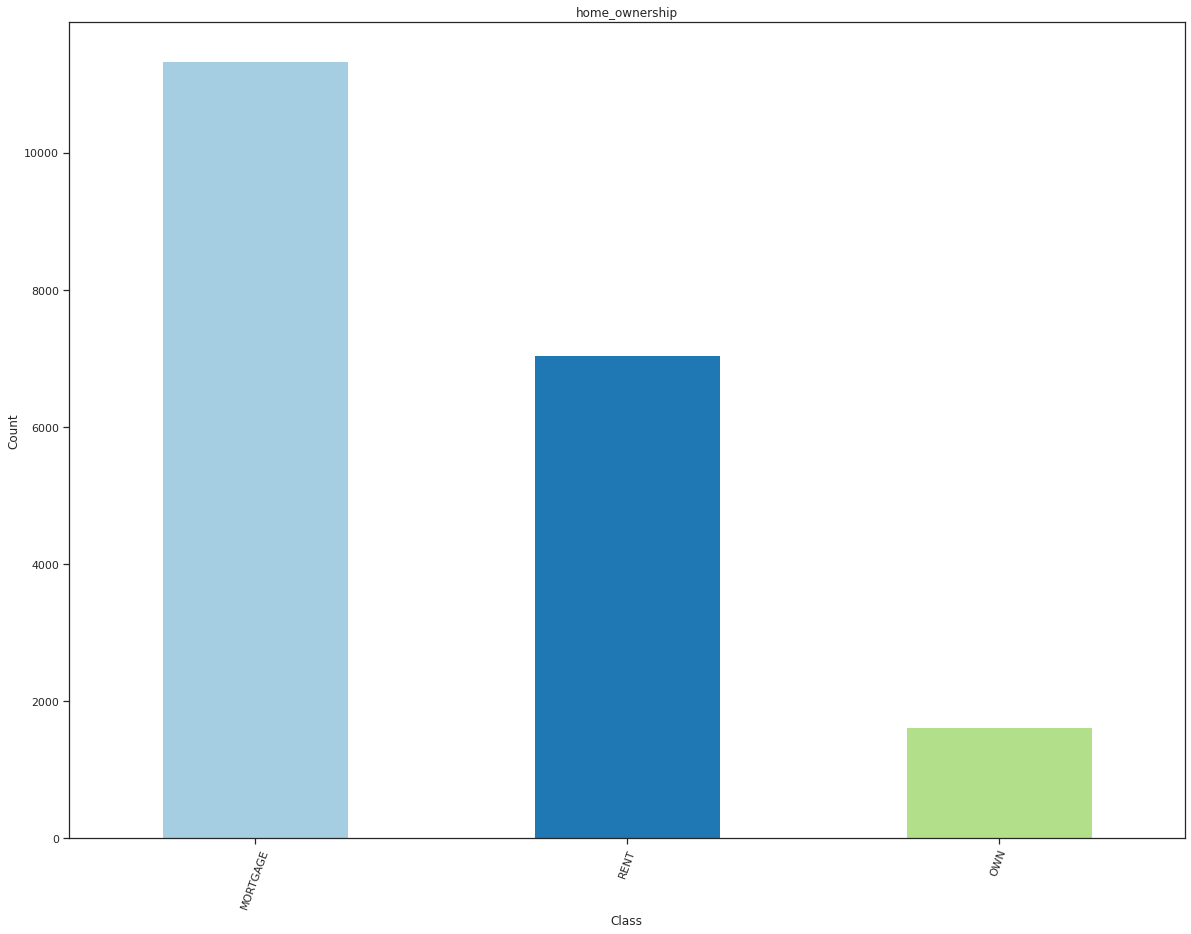

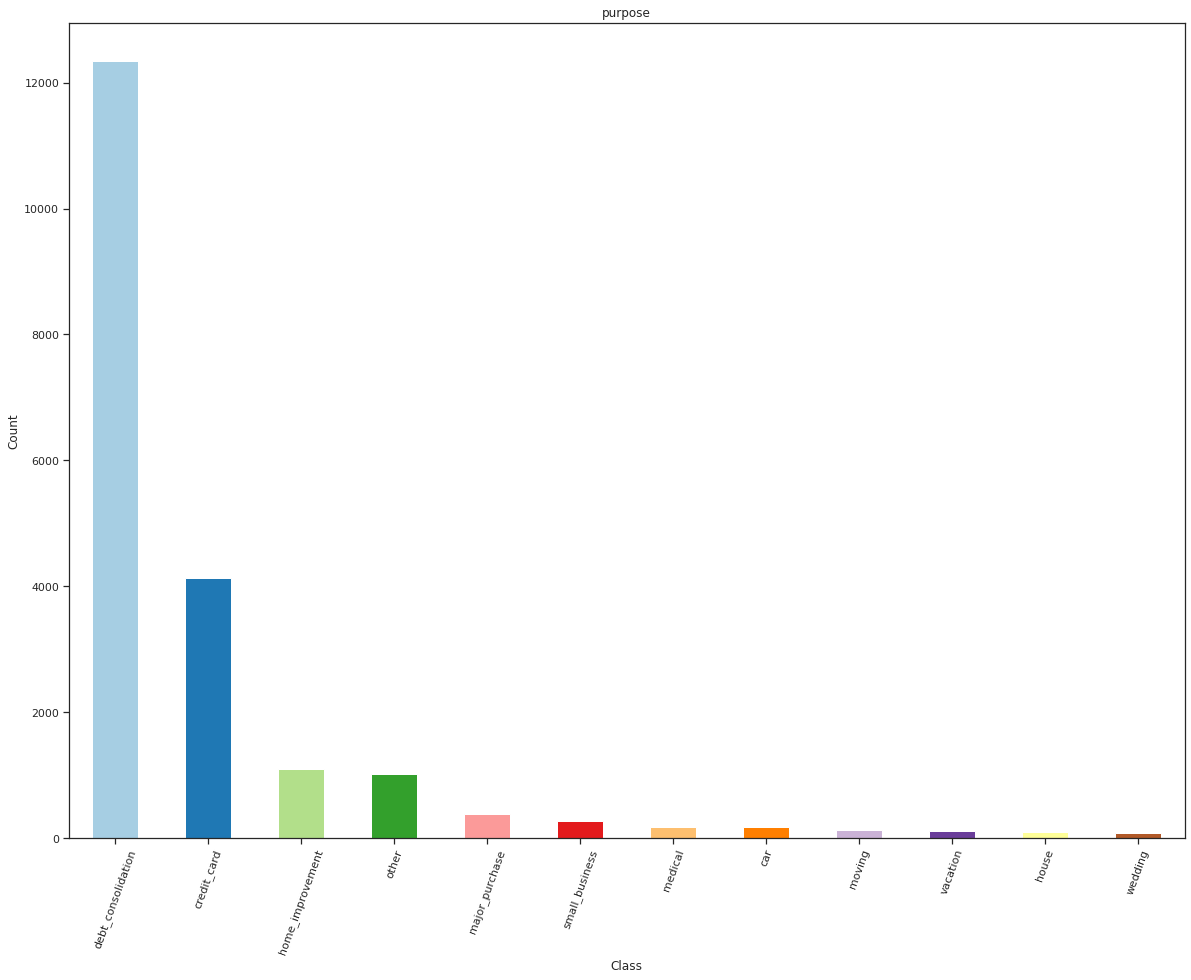

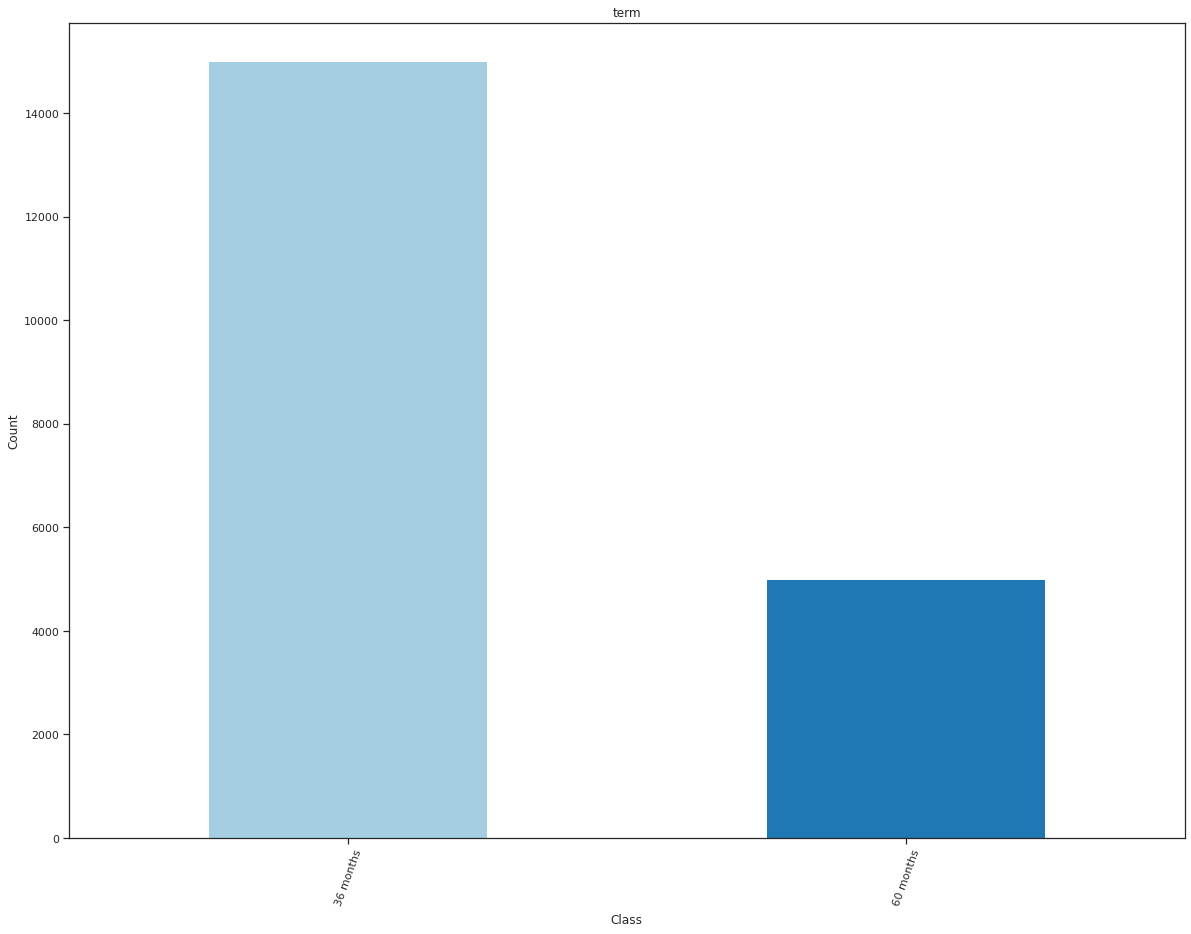

In [486]:
for column in ld.select_dtypes(include=['object']).columns:
  ld[column].value_counts().plot(kind='bar', color=sns.color_palette('Paired'))

  plt.xlabel('Class')
  plt.xticks(rotation=70, horizontalalignment='center')
  plt.ylabel('Count')
  plt.title(column)
  plt.show()

The heatmap below show the correlation between both the target and features in the dataset. We can see the greatest correlations between bad_loan and the features would be dti and total_rec_late_fee. Though these features are not significantly correlated to the target, they would affect the results of the target more than other features. 

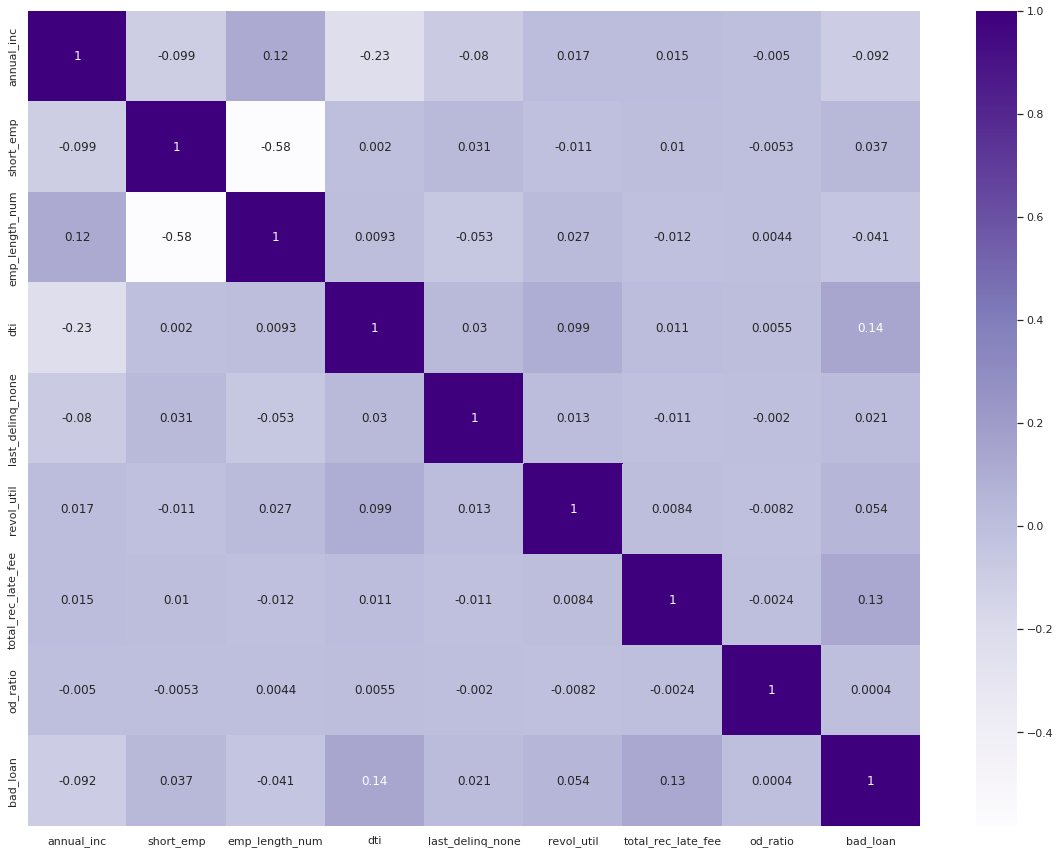

In [487]:
sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(ld.corr(), cmap ="Purples", annot=True);

The scatterplot below show the correlation between the debt-to-income and annual income features with each being marked based on the home ownership feature. From the data, we can determine many low income customers have a mortgage no matter if their debt-to-income ratio is high or low. However, as the annual income increases, we can notice the debt-to-income is less. 

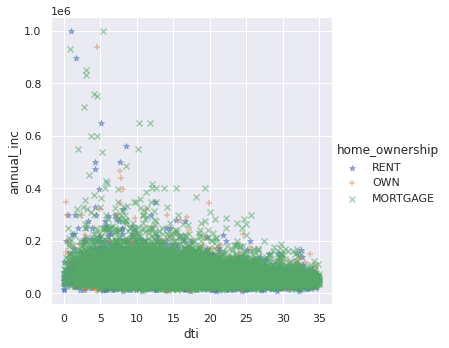

In [488]:
sns.lmplot(x='dti', y='annual_inc', markers=['*','+','x'], hue='home_ownership', 
           data=ld.loc[ld['home_ownership'].isin(['MORTGAGE','RENT','OWN'])],
           scatter_kws={'alpha':0.5}, fit_reg=False);

The boxplot below show the correlation between the annual income and grade features with each grade separated by terms. From the data, we can determine most of our data consists of customers with low annual incomes with a few outliers with high annual incomes of various grades.

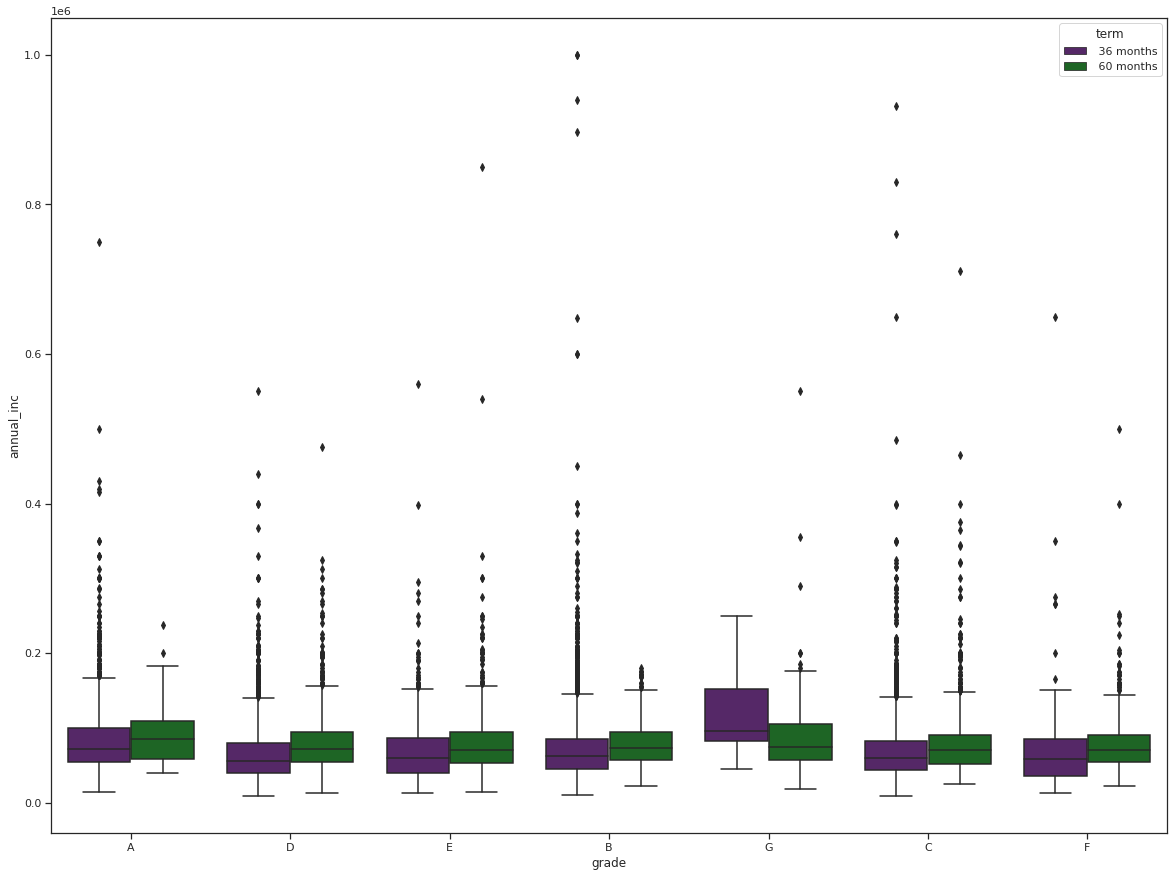

In [489]:
sns.set_theme(style='ticks',palette='dark')
sns.boxplot(x='grade', y='annual_inc', hue='term', data=ld, palette=['m','g']);

**Scale the Data**

Ordinal Encode 'grade' feature

In [490]:
ord_grade = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6}

ld['grade'] = ld['grade'].replace(ord_grade)

Validation Split

In [491]:
X = ld.drop(columns = ['bad_loan'])
y = ld['bad_loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [492]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_selector = make_column_selector(dtype_include='object')
cat_selector(X_train)

['home_ownership', 'purpose', 'term']

In [493]:
train_cat_data = X_train[cat_selector(X_train)]
test_cat_data = X_test[cat_selector(X_test)]
train_cat_data

,home_ownership,purpose,term
5514,MORTGAGE,debt_consolidation,36 months
1266,MORTGAGE,debt_consolidation,36 months
5864,OWN,debt_consolidation,36 months
15865,RENT,credit_card,36 months
12892,MORTGAGE,debt_consolidation,36 months
...,...,...,...
11284,MORTGAGE,credit_card,36 months
11964,RENT,debt_consolidation,36 months
5390,MORTGAGE,other,60 months
860,MORTGAGE,credit_card,36 months


In [494]:
ohe.fit(train_cat_data)

train_ohe = ohe.transform(train_cat_data)
test_ohe = ohe.transform(test_cat_data)
train_ohe

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [495]:
ohe_column_names = ohe.get_feature_names_out(train_cat_data.columns)
train_ohe = pd.DataFrame(train_ohe, columns=ohe_column_names)
test_ohe = pd.DataFrame(test_ohe, columns=ohe_column_names)
train_ohe

,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14996,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14998,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [496]:
num_selector = make_column_selector(dtype_include='number')
train_nums = X_train[num_selector(X_train)].reset_index(drop=True)
test_nums = X_test[num_selector(X_test)].reset_index(drop=True)

In [497]:
X_train_processed = pd.concat([train_nums,train_ohe], axis=1)
X_test_processed = pd.concat([test_nums,test_ohe], axis=1)
X_train_processed

,grade,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,home_ownership_MORTGAGE,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,2,60000.0,0,2,31.26,1,96.7,0.0,0.094220,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,80000.0,0,6,11.33,1,42.1,0.0,0.210340,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,45000.0,0,11,22.15,0,14.8,0.0,0.247907,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,25000.0,0,5,13.37,1,84.8,0.0,0.528846,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,75000.0,0,5,13.68,0,21.4,0.0,0.512339,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,55000.0,0,4,11.15,0,32.3,0.0,0.788303,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14996,1,65000.0,0,6,11.17,1,57.8,0.0,0.556421,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14997,3,95000.0,1,0,14.00,1,33.1,0.0,0.578683,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14998,0,170000.0,0,8,8.55,0,31.9,0.0,0.444177,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [498]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_processed), 
                              columns=X_train_processed.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_processed),
                             columns=X_test_processed.columns)
X_train_scaled.head()

,grade,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,home_ownership_MORTGAGE,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0.009225,-0.299706,-0.353116,-1.282826,1.951086,0.910029,0.869282,-0.094447,-1.433859,0.869381,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754
1,0.009225,0.139864,-0.353116,-0.222069,-0.686555,0.910029,-0.297486,-0.094447,-1.029624,0.869381,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754
2,0.761300,-0.629384,-0.353116,1.103877,0.745420,-1.098866,-0.880871,-0.094447,-0.898847,-1.150244,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754
3,0.761300,-1.068954,-0.353116,-0.487259,-0.416571,0.910029,0.614986,-0.094447,0.079148,-1.150244,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754
4,0.009225,0.029971,-0.353116,-0.487259,-0.375544,-1.098866,-0.739833,-0.094447,0.021683,0.869381,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754


**KMeans Cluster**

From the inertias elbow below, the elbow would be at 4 clusters, though it is difficult to determine from this graph.

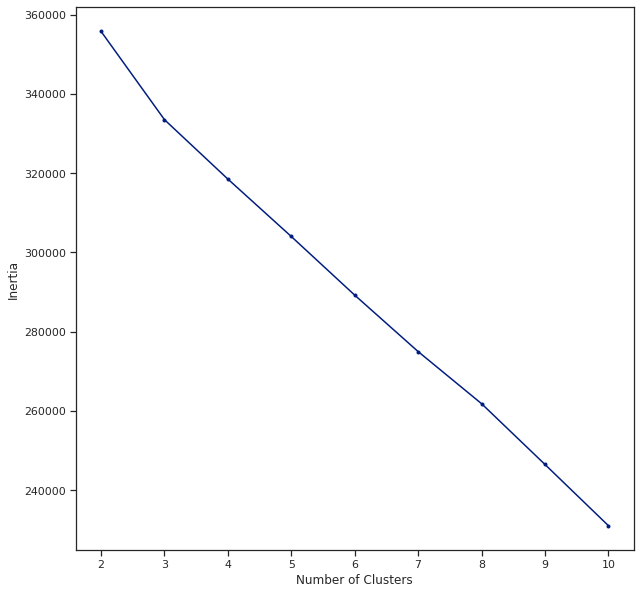

In [508]:
inertias = []

for k in range(2,11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X_train_scaled)
  inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,10))
plt.plot(range(2,11), inertias, marker= '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show;

From the silhouette score graph below, the highest silhouette score would be at 9 clusters.

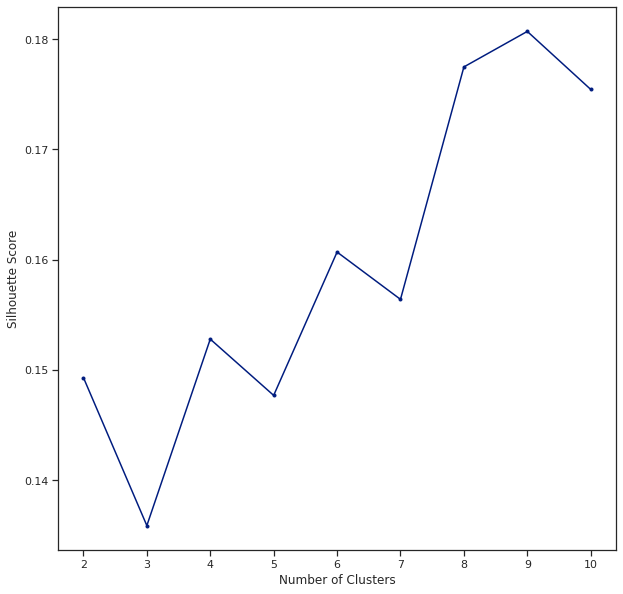

In [506]:
silhouette_scores = []

for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(X_train_scaled)
  silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

plt.figure(figsize=(10,10))
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show;

Since the silhouette score is easier to determine from the graph above, I will choose to go with the silhouette score and refit the KMeans model with 20 clusters.

In [509]:
km = KMeans(n_clusters=9, init='k-means++', random_state=42)
km.fit_predict(X_train_scaled)
silhouette_score(X_train_scaled, km.labels_)

0.1812463409449326

In [510]:
X_train_scaled['cluster'] = km.labels_
X_train_scaled.head()

,grade,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,home_ownership_MORTGAGE,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,cluster
0,0.009225,-0.299706,-0.353116,-1.282826,1.951086,0.910029,0.869282,-0.094447,-1.433859,0.869381,...,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754,3
1,0.009225,0.139864,-0.353116,-0.222069,-0.686555,0.910029,-0.297486,-0.094447,-1.029624,0.869381,...,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754,3
2,0.761300,-0.629384,-0.353116,1.103877,0.745420,-1.098866,-0.880871,-0.094447,-0.898847,-1.150244,...,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754,4
3,0.761300,-1.068954,-0.353116,-0.487259,-0.416571,0.910029,0.614986,-0.094447,0.079148,-1.150244,...,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754,1
4,0.009225,0.029971,-0.353116,-0.487259,-0.375544,-1.098866,-0.739833,-0.094447,0.021683,0.869381,...,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.5754,-0.5754,3


In [511]:
cluster_groups = X_train_scaled.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,grade,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,-0.048189,-0.271993,2.831933,-1.637567,0.011364,0.083813,-0.005508,-0.020396,-0.012918,...,-0.070412,0.028039,-0.004462,0.106431,0.020455,-0.114467,-0.075937,-0.021545,0.145829,-0.145829
1,1,-0.132561,-0.248686,-0.353116,-0.020101,-0.037002,0.021112,-0.011653,0.000316,0.004907,...,-0.070412,0.035213,0.027789,0.061746,0.043667,-0.114467,-0.075937,0.047903,0.575400,-0.575400
2,2,0.827323,0.134344,-0.347957,0.285372,0.135128,0.009378,0.117692,0.030473,-0.013510,...,-0.070412,-0.037251,-0.030594,-0.032917,-0.035354,-0.114467,-0.075937,-0.029081,-1.737172,1.737172
3,3,-0.425576,0.172974,-0.353116,0.314412,-0.042983,-0.049304,-0.015620,-0.024097,0.020088,...,-0.070412,-0.005918,0.012623,-0.042899,-0.014202,-0.114467,-0.075937,-0.006568,0.575400,-0.575400
4,4,0.030790,-0.149724,0.057858,-0.051455,0.078463,0.013587,-0.092917,-0.038431,-0.003064,...,-0.070412,0.048046,-0.016164,0.001781,0.105137,-0.114467,-0.075937,0.019374,0.032309,-0.032309
5,5,1.075311,0.361786,0.008075,-0.127750,-0.293198,0.019488,-0.175384,0.419948,-0.021588,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,8.736108,-0.075937,-0.064424,-0.211606,0.211606
6,6,0.551419,-0.045704,-0.130903,0.135628,-0.052698,0.139174,-0.132749,0.102620,-0.196612,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,13.168850,-0.064424,0.387107,-0.387107
7,7,0.080368,0.381030,0.120337,-0.229237,-0.536333,0.068465,-0.484729,0.397109,-0.274843,...,14.202208,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,-0.143605,0.143605
8,8,-0.207281,-0.120392,0.153597,-0.278322,-0.455896,0.042552,-0.346312,-0.094447,-0.150874,...,-0.070412,-0.143342,-0.093501,-0.078557,-0.232299,-0.114467,-0.075937,-0.064424,0.277472,-0.277472


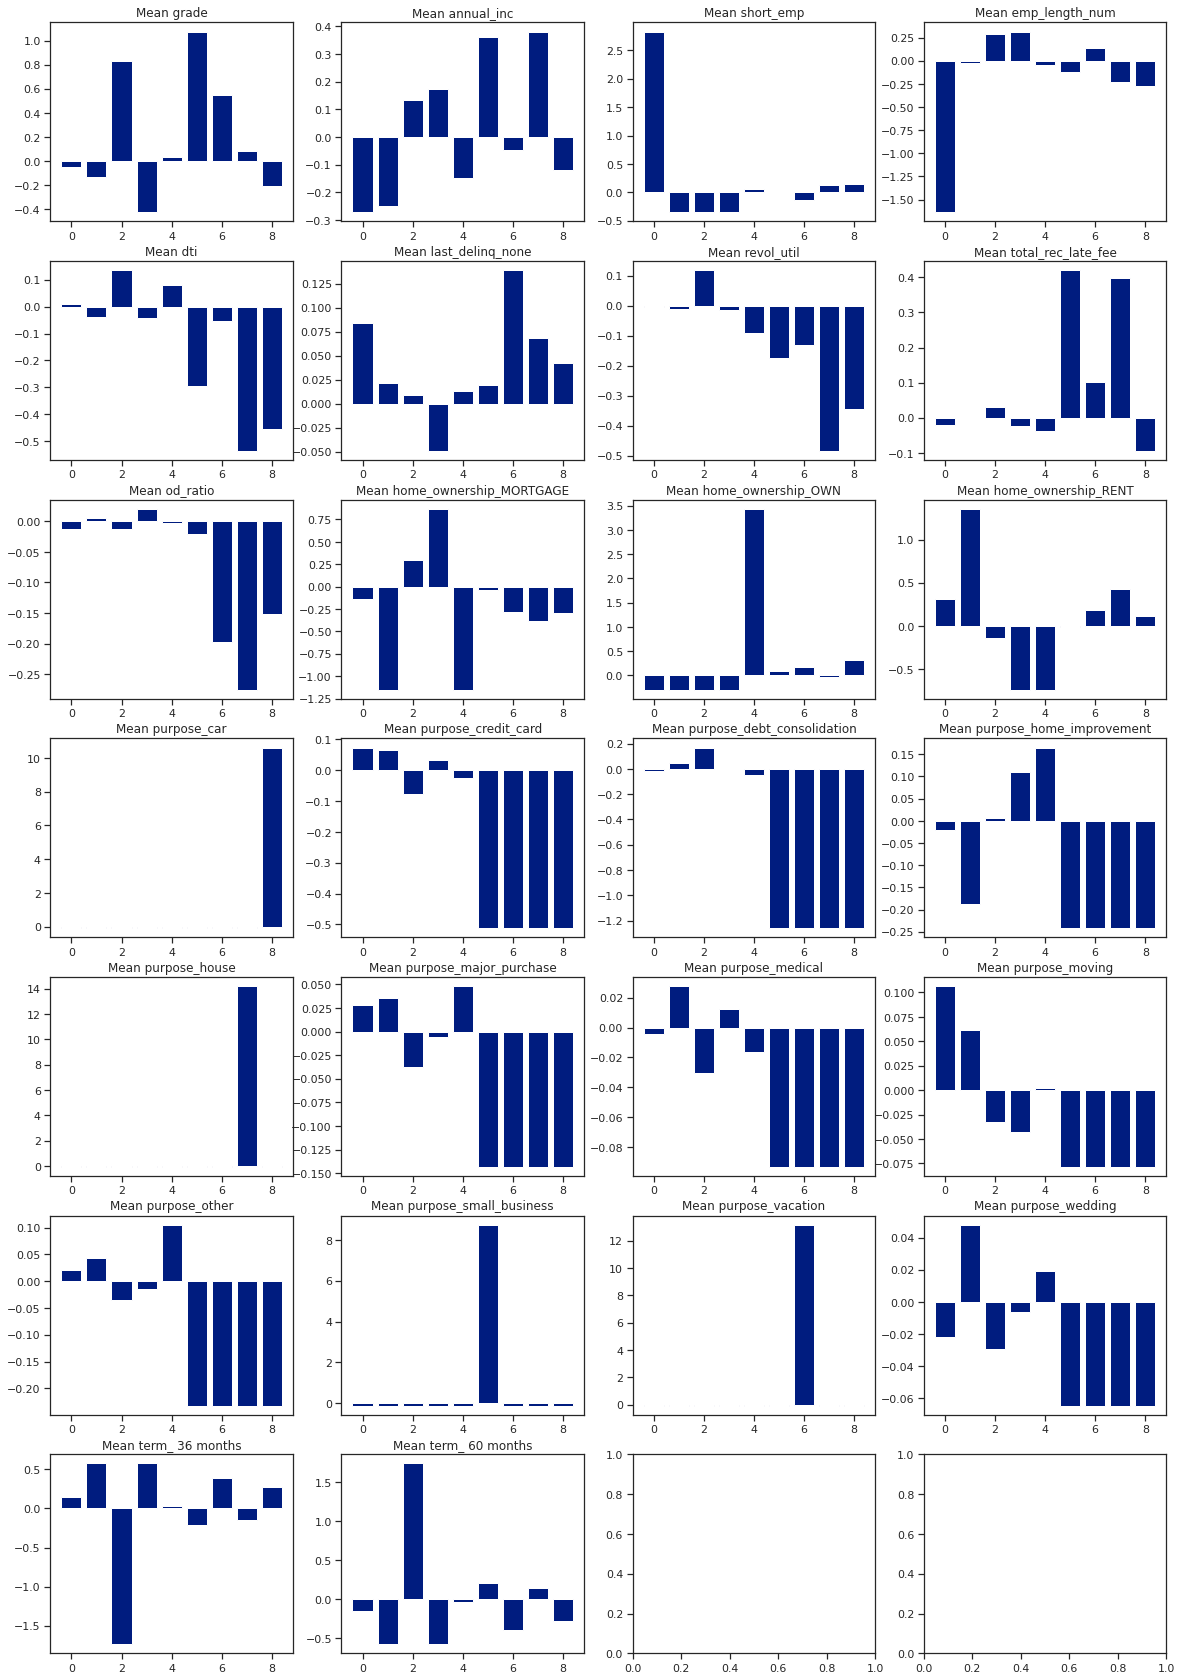

In [512]:
fig, axes = plt.subplots(7, 4, figsize=(20,30))
axes = axes.ravel()

for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

Hierarchical Cluster 

In [513]:
hc = AgglomerativeClustering(n_clusters= 20)
hc.fit(X_train_scaled)

AgglomerativeClustering(n_clusters=20)

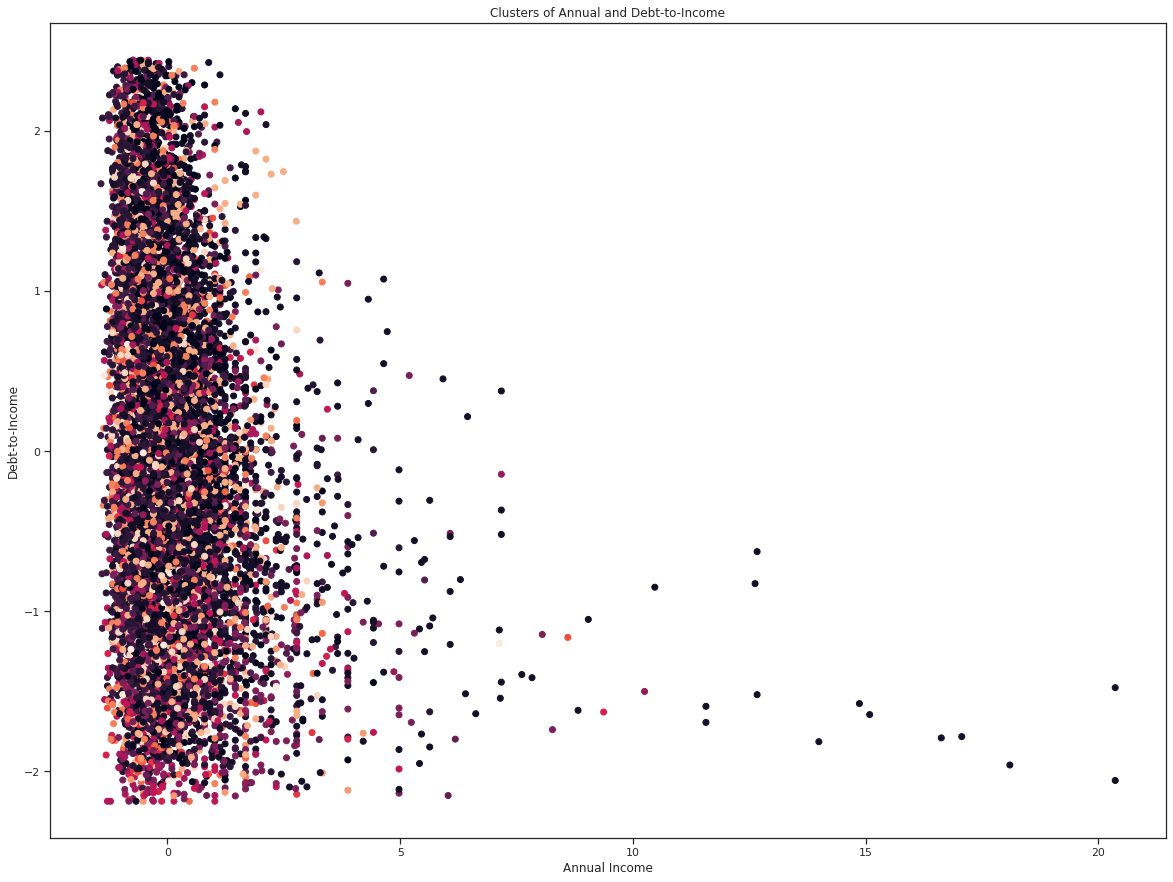

In [521]:
X_train_scaled['cluster'] = hc.labels_

plt.scatter(x= X_train_scaled['annual_inc'], y= X_train_scaled['dti'], 
            c= X_train_scaled['cluster'])
plt.xlabel('Annual Income')
plt.ylabel('Debt-to-Income')
plt.title('Clusters of Annual and Debt-to-Income');